# Example of usage Spark OCR with Dicom Image Deidentifier

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
# install from PYPI using secret
%pip install --upgrade spark-nlp-jsl==4.0.0  --extra-index-url https://pypi.johnsnowlabs.com/$nlp_secret
%pip install spark-nlp==4.0.0
%pip install spark-ocr==$version+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
%pip install pydicom

In [ ]:
#%pip install ../../python/dist/spark-ocr-4.0.0rc2+spark32.tar.gz

## Initialization of spark session

In [ ]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal="4.0.0")

spark

## Import Spark OCR transformers and Spark NLP annotators

In [3]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 4.0.0
Spark NLP internal version: 4.0.0
Spark OCR version: 4.0.0rc2


## Define de-identification  NLP pipeline

In [4]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [10]:
from pyspark.ml import PipelineModel, Pipeline

# Extract images from Dicom foram
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setKeepInput(True)

scaler = ImageScaler() \
    .setScaleFactor(3) \
    .setInputCol("image_raw") \
    .setOutputCol("image_scaled")

ocr = ImageToText() \
    .setInputCol("image_scaled") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setModelType(ModelType.BEST) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True)

# Found sensitive data using DeIdentificationModel
deidentification_rules = DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token","metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")


# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(10) \
    .setPadding(0)

# Draw filled rectangle for hide sensitive data
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setScaleFactor(1/3.0)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")

# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    scaler,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix=""),
    position_finder,
    draw_regions,
    dicom_deidentifier
])

deidentify_rb_no_regex download started this may take some time.
Approximate size to download 8.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


## Read dicom objects as binary file and display metadata


### Useful Patient Identification Tags to check
 - (00100010)	PN	Patient Name
 - (00100020)	LO	Patient ID
 - (00100030)	DA	Patient's Birth Date
 - (00100040)	CS	Patient's Sexe
 - (00101010)	AS	Patient's Age
 - (00101030)	DS	Patient's Weight

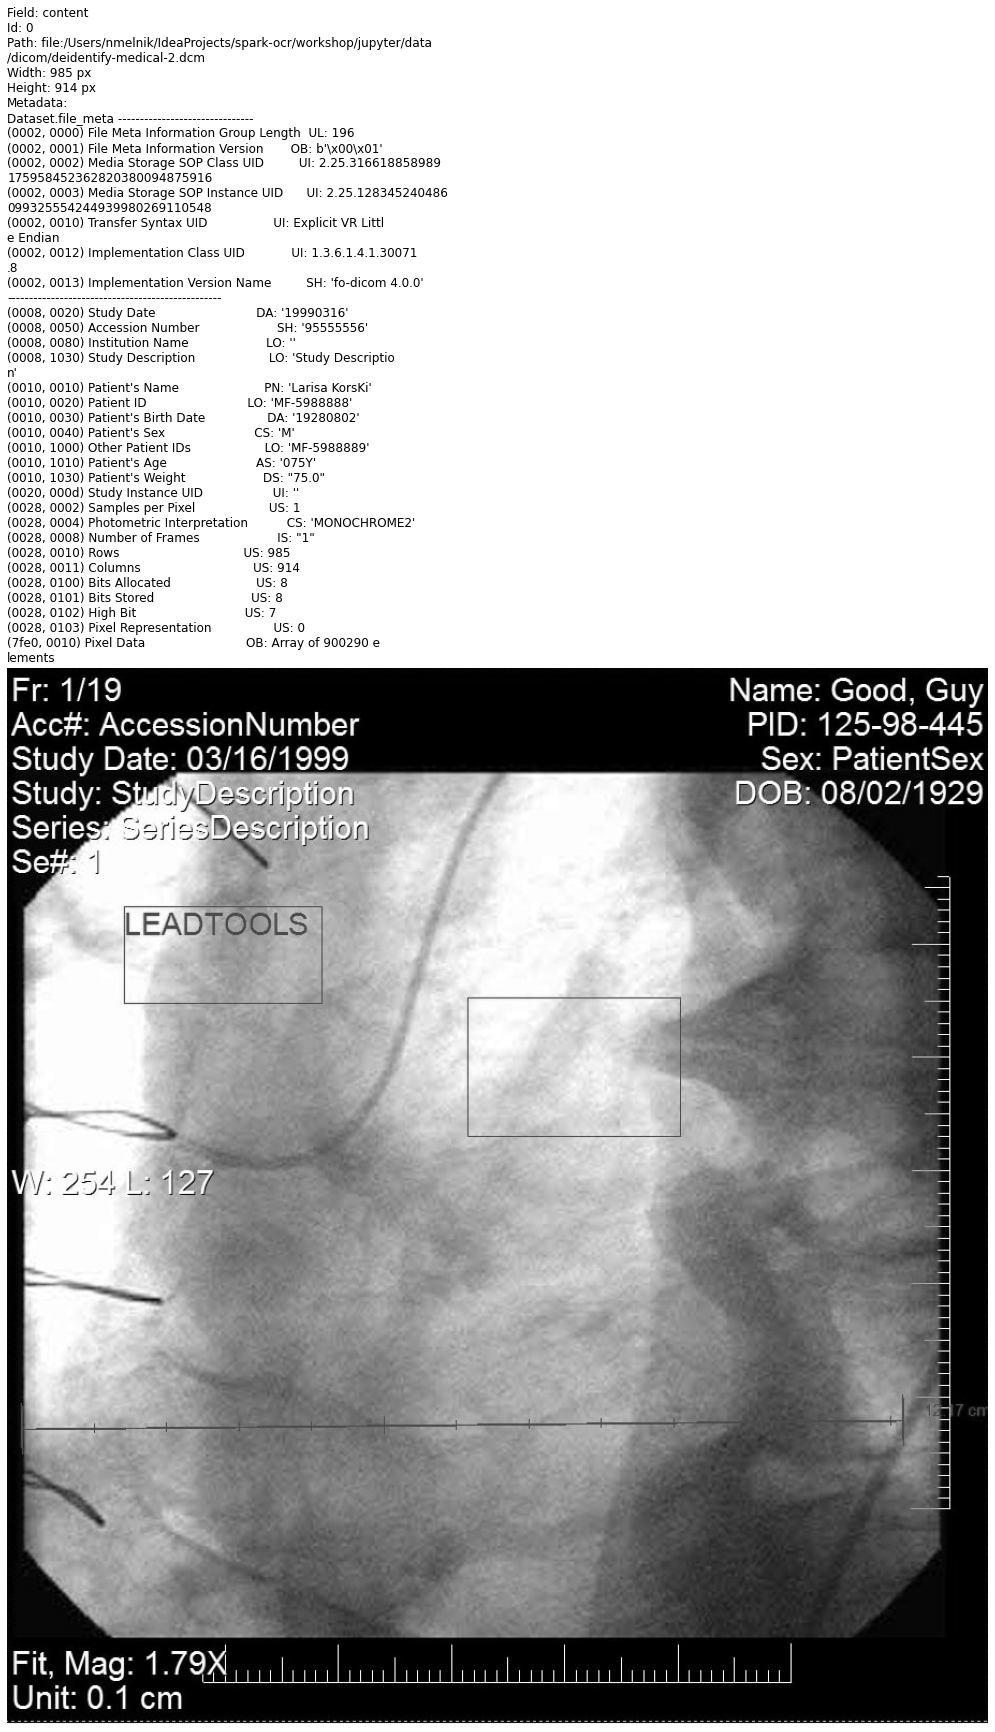

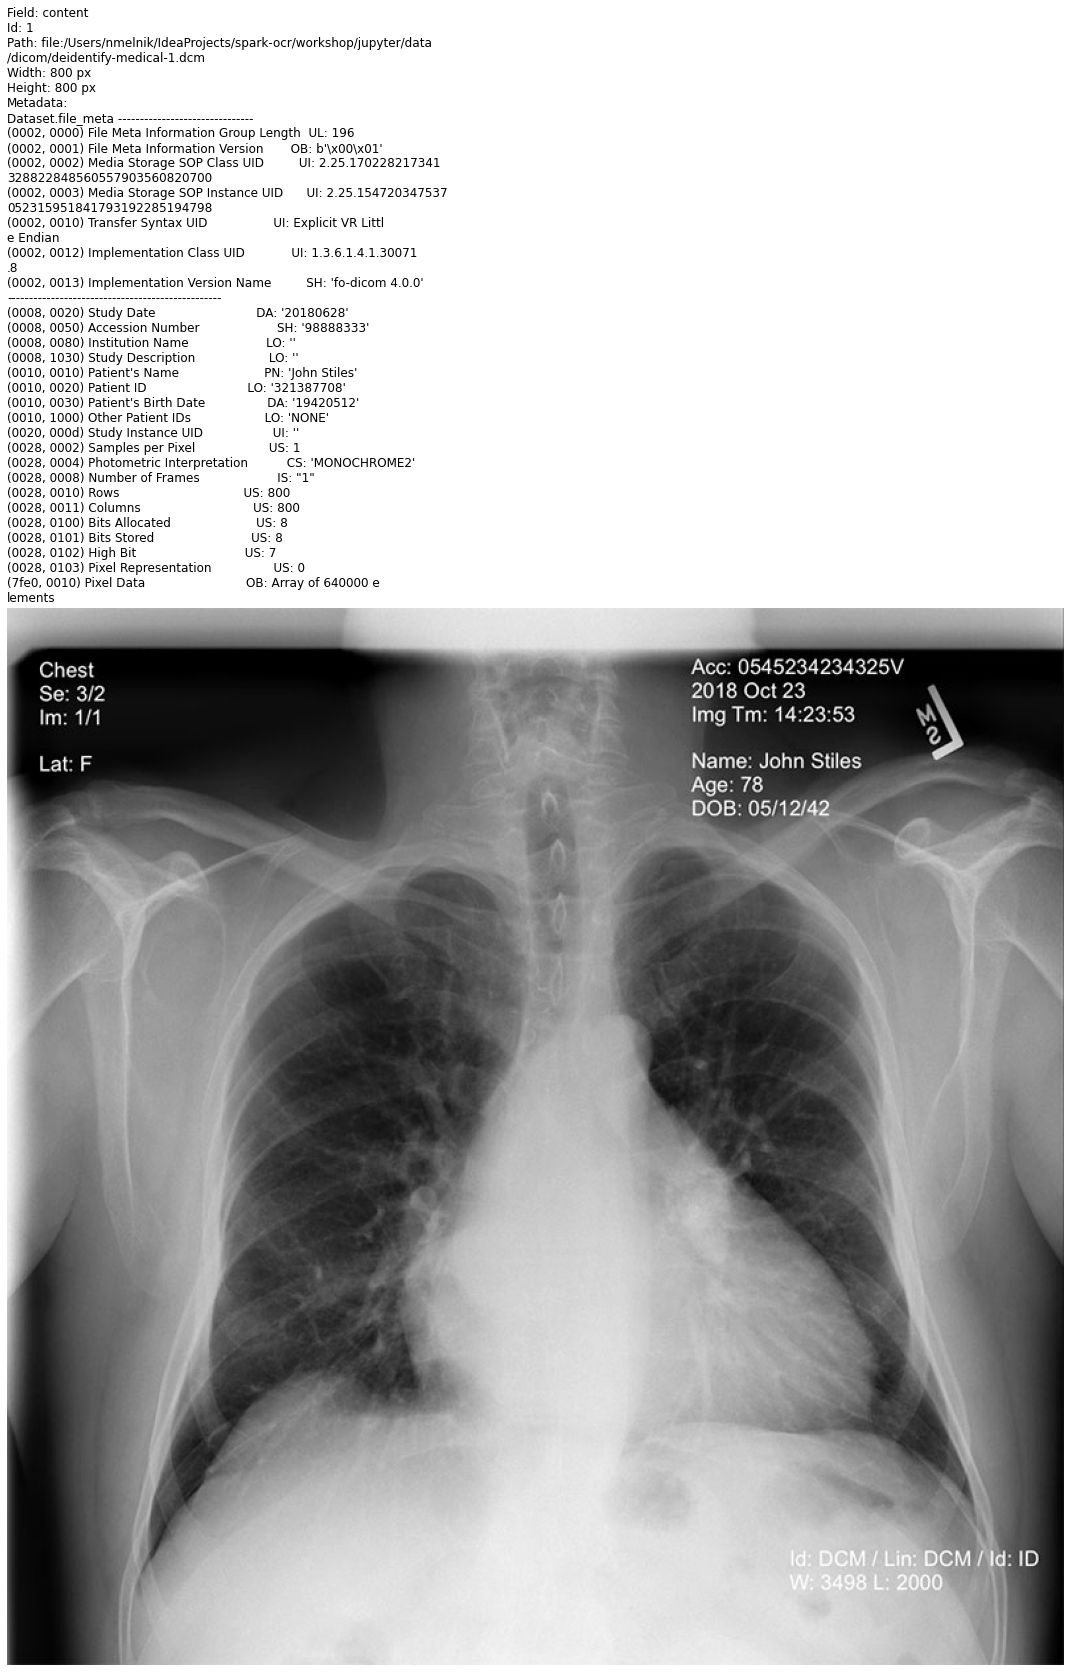

In [11]:
dicom_path = '././data/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path)

display_dicom(dicom_df)

In [12]:
result = pipeline.transform(dicom_df).cache()

result.select("ner_chunk").show(10, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ner_chunk                                                                                                                                                                                                                                                                                                                                                                                                         |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Show original and de-identified dicom

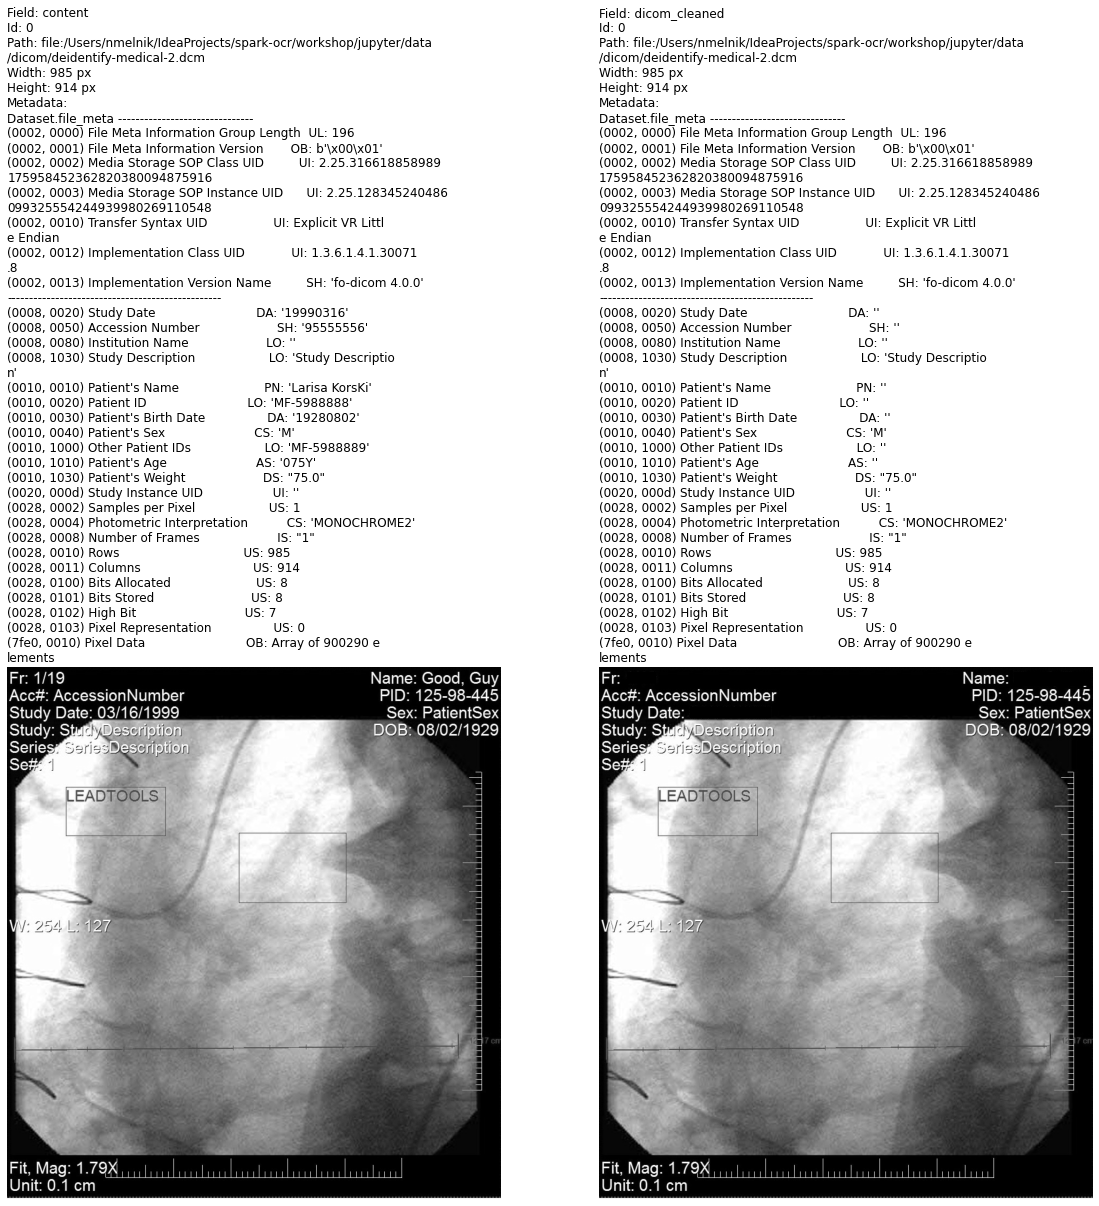

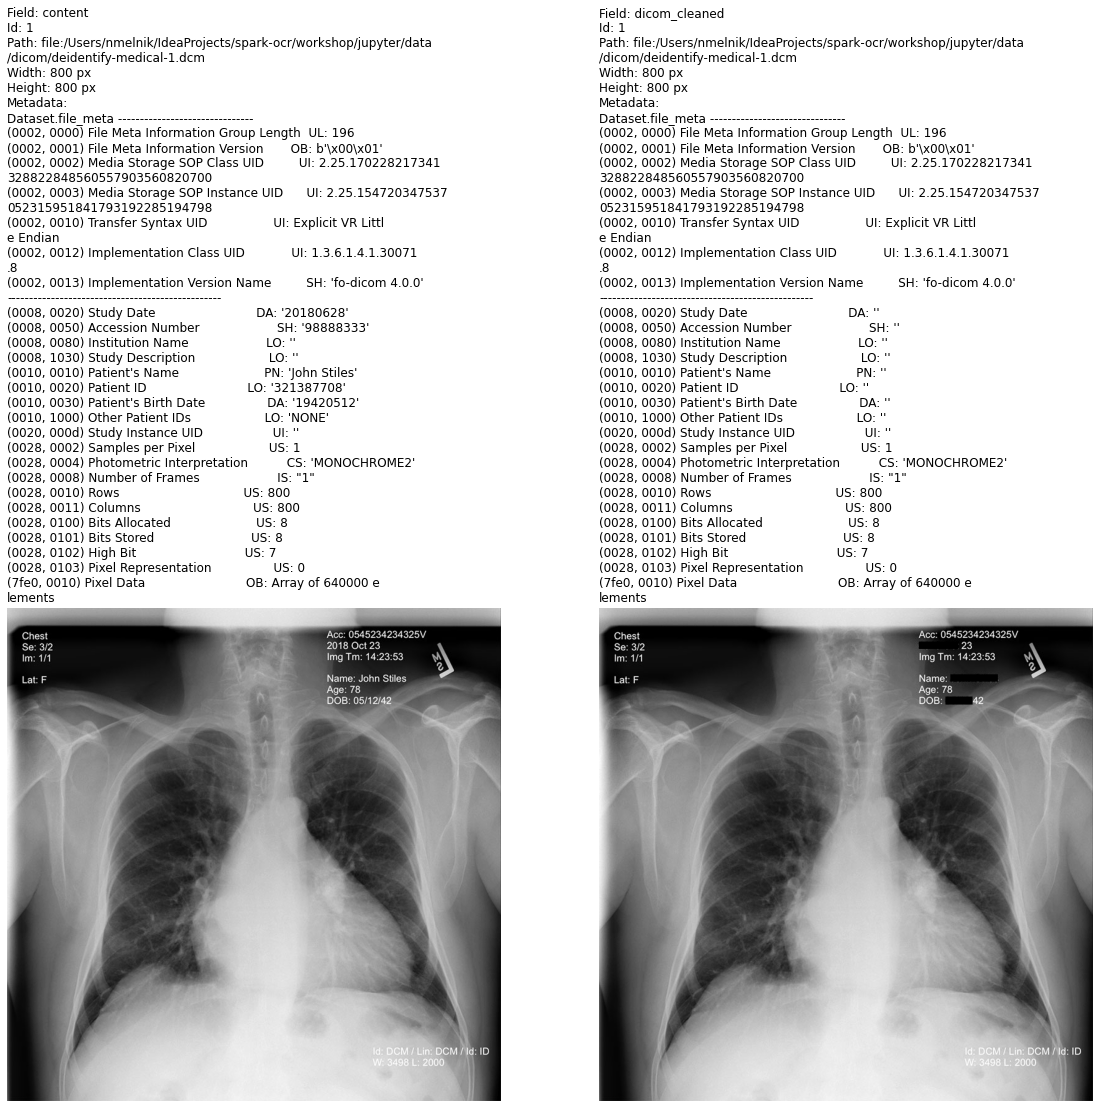

In [13]:
display_dicom(result, "content,dicom_cleaned")

## Run pipeline and store result

In [14]:
# NBVAL_SKIP

output_path = "././data/dicom/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in result.select("dicom_cleaned", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join(output_path, filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom_cleaned)

Storing to ././data/dicom/deidentified/deidentify-medical-2.dcm
Storing to ././data/dicom/deidentified/deidentify-medical-1.dcm


## Display Deidentified Image and Deidentified metadata

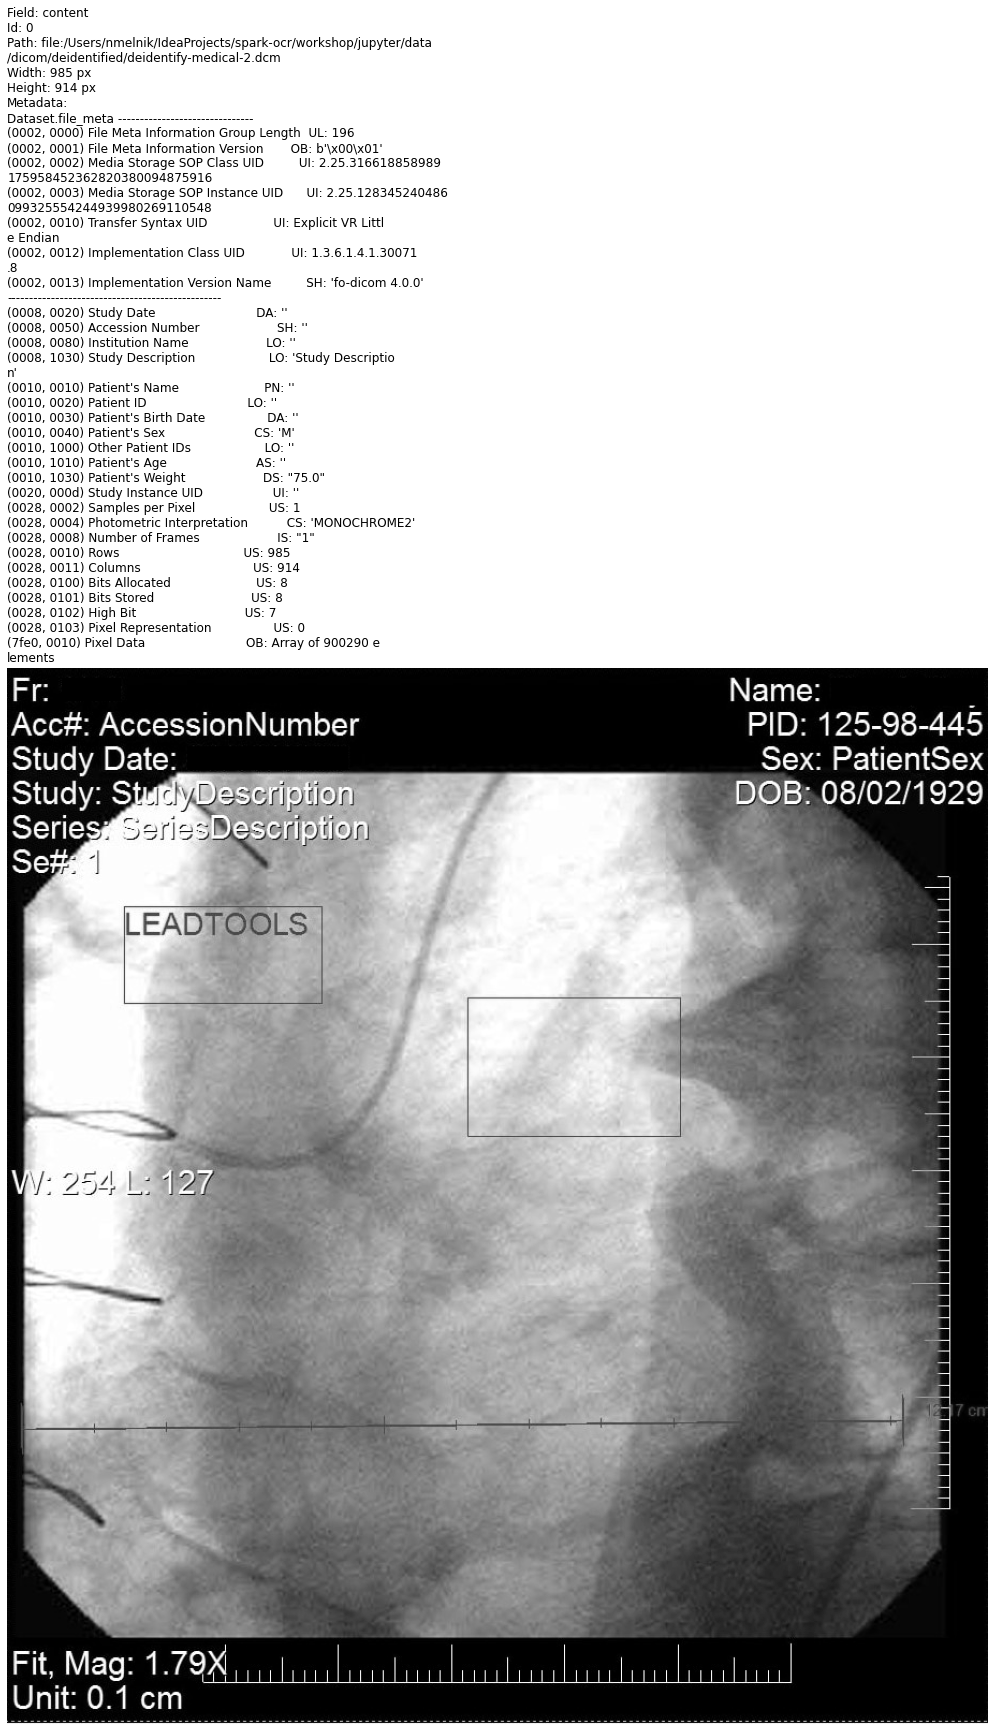

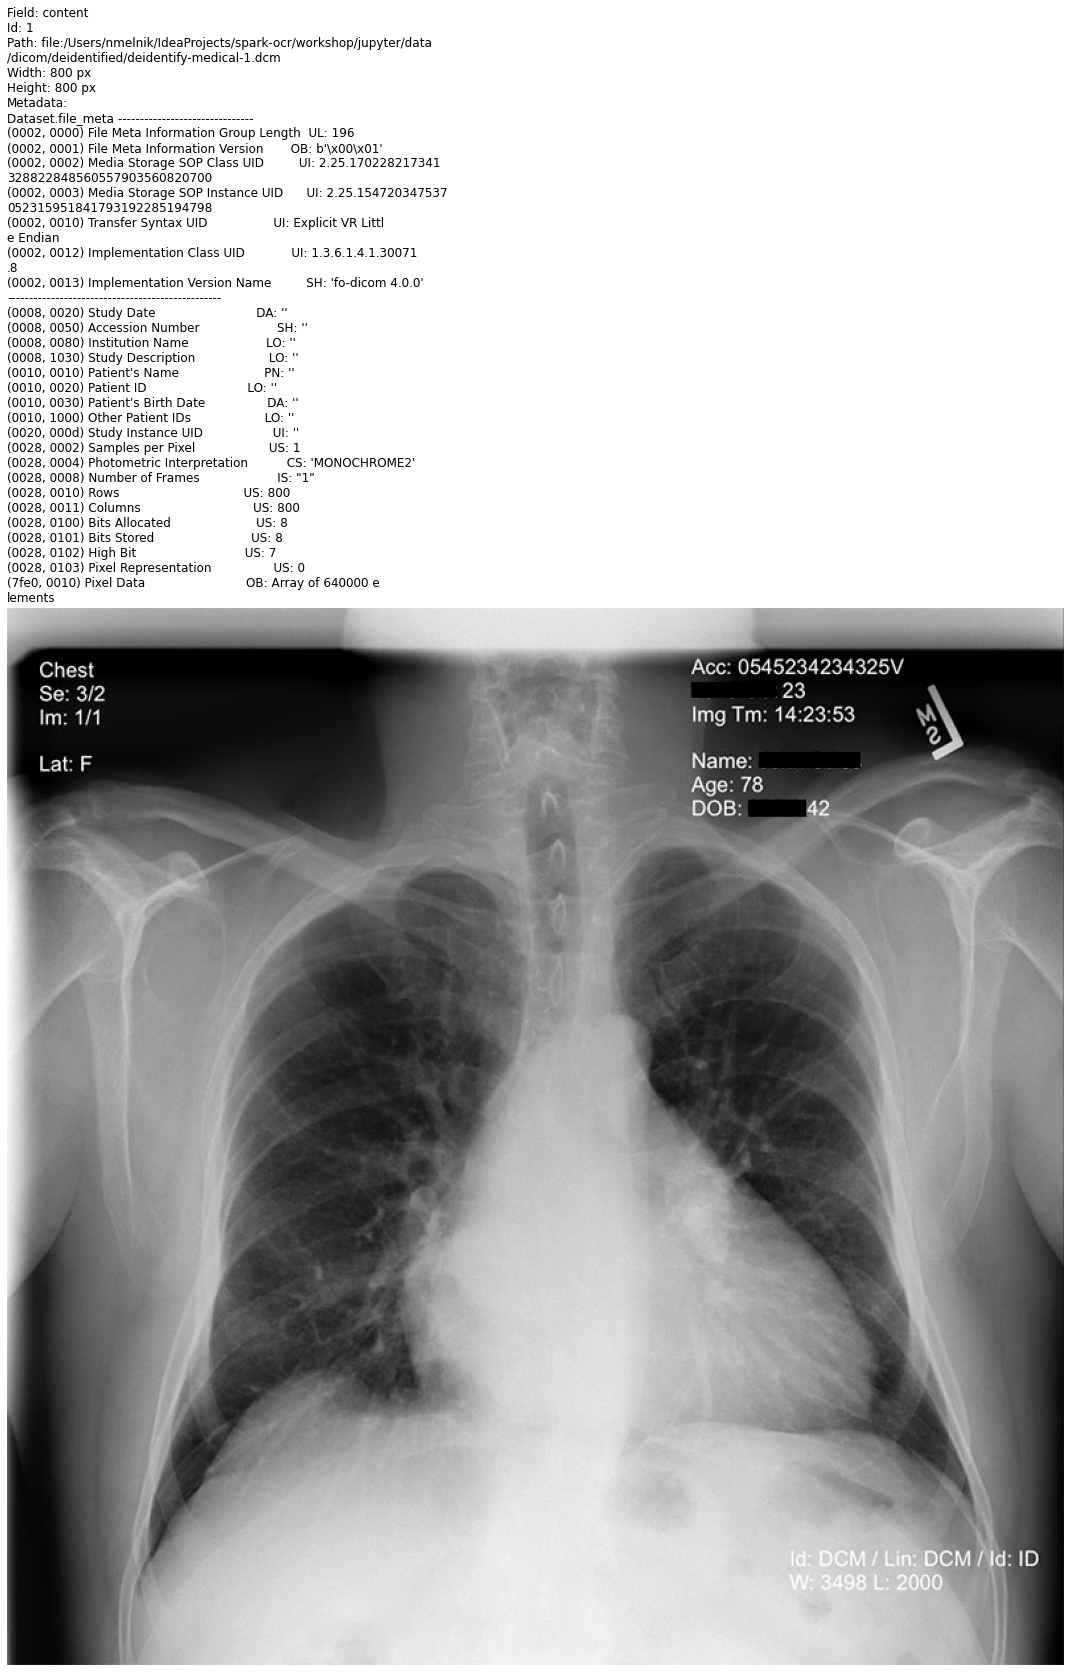

In [15]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("././data/dicom/deidentified/*.dcm")

display_dicom(dicom_gen_df)

## Remove reults

In [16]:
%%bash
rm -r -f ././data/dicom/deidentified